# Analisi delle performance
## Passo 1: Generare dati
Automatizziamo la generazione di dati con il seguente blocco di codice che ci consente di ottenere informazioni sulle performance dell'algoritmo.
Possiamo modificare le variabili di N_PROCESSORI, N_START_INPUT, STRATEGIA, OFFSET e N_CICLI per ottenere set di informazioni diversi.

In [4]:
import subprocess

N_PROCESSORI = 4
N_START_INPUT = 2000
STRATEGIA = 3
OFFSET = 1000
N_CICLI = 5

for i in range(N_CICLI):
    comando = ["mpirun", "-n", str(N_PROCESSORI), "./pdc1", str(STRATEGIA), str(N_START_INPUT)]
    try:
        subprocess.run(comando, text=True, capture_output=True, check=True)
    except subprocess.CalledProcessError as e:
        exit(1)
    N_START_INPUT += OFFSET


## Passo 2: Analizzare le informazioni estratte
Il seguente script si occupa della lettura del file CSV per estrarre i dati di nostro interesse e costruire i grafici

IndexError: single positional indexer is out-of-bounds

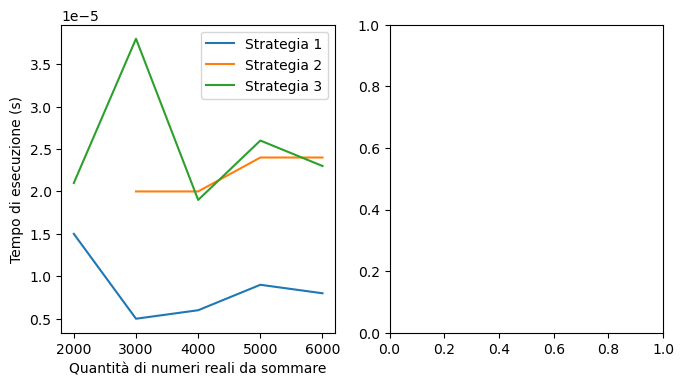

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Leggi il file CSV
data = pd.read_csv('output/analytics_data.csv')

strategy1_data = data[data.iloc[:, 2] == 1]  # Terza colonna (numero della strategia)
strategy2_data = data[data.iloc[:, 2] == 2]
strategy3_data = data[data.iloc[:, 2] == 3]

# Crea i grafici per la quarta colonna (tempo di esecuzione)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(strategy1_data.iloc[:, 1], strategy1_data.iloc[:, 3], label='Strategia 1')  # Seconda colonna (tempo di esecuzione)
plt.plot(strategy2_data.iloc[:, 1], strategy2_data.iloc[:, 3], label='Strategia 2')
plt.plot(strategy3_data.iloc[:, 1], strategy3_data.iloc[:, 3], label='Strategia 3')
plt.xlabel('Quantità di numeri reali da sommare')
plt.ylabel('Tempo di esecuzione (s)')
plt.legend()


# Crea i grafici per la quinta colonna (speed up)
plt.subplot(132)
plt.plot(strategy1_data.iloc[:, 1], strategy1_data.iloc[:, 4], label='Strategia 1')  # Seconda colonna (speed up)
plt.plot(strategy2_data.iloc[:, 1], strategy2_data.iloc[:, 4], label='Strategia 2')
plt.plot(strategy3_data.iloc[:, 1], strategy3_data.iloc[:, 4], label='Strategia 3')
plt.xlabel('Quantità di numeri reali da sommare')
plt.ylabel('Speed Up')
plt.legend()

# Crea i grafici per la sesta colonna (speed up normalizzato)
plt.subplot(133)
plt.plot(strategy1_data.iloc[:, 1], strategy1_data.iloc[:, 5], label='Strategia 1')  # Seconda colonna (speed up normalizzato)
plt.plot(strategy2_data.iloc[:, 1], strategy2_data.iloc[:, 5], label='Strategia 2')
plt.plot(strategy3_data.iloc[:, 1], strategy3_data.iloc[:, 5], label='Strategia 3')
plt.xlabel('Quantità di numeri reali da sommare')
plt.ylabel('Efficienza')
plt.legend()

plt.tight_layout()
plt.show()


# Calcolo lo speedup

In [4]:
import pandas as pd

# Carica il CSV in un DataFrame
df = pd.read_csv('output_sorted.csv')

# 1. Pulisci i dati
df = df[df['NPROC'].isin([1, 8])]

# 2. Calcola le medie
df_grouped = df.groupby(['NPROC', 'NINPUT', 'STRATEGIA']).agg({'TEMPO': 'mean'}).reset_index()

# 3. Ricrea il set di dati
df_grouped.to_csv('dati_medi.csv', index=False)

# 4. Calcola il rapporto tra i tempi
df_nproc1 = df_grouped[df_grouped['NPROC'] == 1].set_index(['NINPUT', 'STRATEGIA'])
df_nproc8 = df_grouped[df_grouped['NPROC'] == 8].set_index(['NINPUT', 'STRATEGIA'])

rapporto_tempi = (df_nproc1['TEMPO'] / df_nproc8['TEMPO']).reset_index()

# Salva solo le righe con tempo
rapporto_tempi = rapporto_tempi.dropna(subset=['TEMPO'])

# Rinomina TEMPO in SPEEDUP
rapporto_tempi = rapporto_tempi.rename(columns={'TEMPO': 'SPEEDUP'})

# Aggiungi la colonna EFFICIENZA
rapporto_tempi['EFFICIENZA'] = rapporto_tempi['SPEEDUP'] / 8

rapporto_tempi.to_csv('rapporto_tempi.csv', index=False)